In [1]:
%matplotlib inline
import time
import numpy as np
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.interpolate import *
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import os, sys
from time import sleep, monotonic
from scipy.ndimage import gaussian_filter

import qcodes as qc
from qcodes import Parameter
from qcodes import initialise_or_create_database_at
from qcodes import load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter

sys.path.append('M:\\tnw\\ns\\qt\\2D Topo\\code\\qcodes')

In [2]:
dirpath = os.getcwd()
sample_name = dirpath.split('\\')[-2]
wafer_name = dirpath.split('\\')[-3]
db_path = dirpath.rsplit('\\', 1)[0] + '\\data'

In [3]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(db_path):
    for file in f:
        if '.db' in file:
            files.append(os.path.join(r, file))

for f in files:
    print(f)

M:\tnw\ns\qt\2D Topo\samples\InSb\M01-28-19.1\17\data\M01-28-19.1_17_2020-12-24_01.db
M:\tnw\ns\qt\2D Topo\samples\InSb\M01-28-19.1\17\data\M01-28-19.1_17_2020-12-24_01.db-wal
M:\tnw\ns\qt\2D Topo\samples\InSb\M01-28-19.1\17\data\M01-28-19.1_17_2020-12-24_01.db-shm


In [4]:
db_path = os.path.join(db_path, 'M01-28-19.1_17_2020-12-24_01.db')
initialise_or_create_database_at(db_path)

In [5]:
import matplotlib

In [6]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

# Smooth dirivative

In [7]:
def smooth_dir(parametr, N_points = 5):
    
    #parametr => current_DC
    #Ny => Ngate
    #Nx => Nvolt
    
    Ny = parametr.shape[0]
    Nx = parametr.shape[1]
    
    d_parameter = np.zeros_like(parametr)
    
    for y_idx in range(Ny): #for each gate value
        for x_idx in range (Nx): #for each voltage point
            vals_to_fit = parametr[y_idx, max(0,x_idx-N_points):min(Nx, x_idx+N_points)] #select current values to fit
            x_axes = np.arange(vals_to_fit.size) #array from 0 to 2*Npoints+1 of integers (fitting length)
            fit_vals = np.polyfit(x_axes, vals_to_fit, 1) #directly use x_axes, because we take derivative with step
            d_parameter[y_idx, x_idx] = fit_vals[0] #derivative with respect to index
            
    return d_parameter

# Loading data

In [9]:
qc.experiments()

[I_vs_Vtg#TL1#1@M:\tnw\ns\qt\2D Topo\samples\InSb\M01-28-19.1\17\data\M01-28-19.1_17_2020-12-24_01.db
 ----------------------------------------------------------------------------------------------------
 1-results-1-appl_TG,meas_current_K1,meas_leakage-1200,
 I_vs_Vgate_up#TL1_3um#2@M:\tnw\ns\qt\2D Topo\samples\InSb\M01-28-19.1\17\data\M01-28-19.1_17_2020-12-24_01.db
 -------------------------------------------------------------------------------------------------------------
 2-results-1-appl_TG,meas_current_K1-400,
 I_vs_Vgate_down#TL1_3um#3@M:\tnw\ns\qt\2D Topo\samples\InSb\M01-28-19.1\17\data\M01-28-19.1_17_2020-12-24_01.db
 ---------------------------------------------------------------------------------------------------------------
 3-results-1-appl_TG,meas_current_K1-400,
 I_vs_Vtg#TL1#4@M:\tnw\ns\qt\2D Topo\samples\InSb\M01-28-19.1\17\data\M01-28-19.1_17_2020-12-24_01.db
 ----------------------------------------------------------------------------------------------------
 4-r

In [ ]:
dataset = qc.load_by_id(23)
print(dataset.exp_name)
cmap = plt.get_cmap('hot')
axes = plot_dataset(dataset, cmap = cmap)
axes
#plt.savefig('../plots/TL2_JJL_IV_1.png')

## Get R from slop

In [ ]:
dataset = qc.load_by_id(32)
voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
fit_values = np.polyfit(current,voltage,1)
print(np.abs(fit_values[0]))

In [ ]:
dataset = qc.load_by_id(9)
dataset.get_parameter_data()['meas_voltage_K1'].keys()

## Rac vs gate

In [75]:
dataset_ids = np.arange(12,16) #12,17

In [76]:
dataset = qc.load_by_id(dataset_ids[0])
vgate = dataset.get_parameter_data()['meas_voltage_Lockin1']['appl_TG']
current_AC = dataset.snapshot['station']['parameters']['appl_current_AC']['value']

Rs_sq = np.zeros_like(vgate)
Rs_contact = np.zeros_like(vgate)

all_Rs = np.zeros( (np.size(vgate),np.size(dataset_ids)) )
lengths = np.zeros_like(dataset_ids)

for idx, dataid in enumerate(dataset_ids):
    dataset = qc.load_by_id(dataid)
    length = dataset.snapshot['station']['parameters']['Segment_length']['value']
    print(length)
    v_ac = dataset.get_parameter_data()['meas_voltage_Lockin1']['meas_voltage_Lockin1']
    all_Rs[:,idx] = 10 * v_ac/current_AC
    lengths[idx] = length
    
for gate_idx,val in enumerate(vgate):
    resistances_to_fit = all_Rs[gate_idx]
    fit_vals = np.polyfit(lengths, resistances_to_fit, 1)
    R_sq = 10 * fit_vals[0] #width 10um
    R_contact = fit_vals[1] / 2 * 10 #2 contacts, 10um wide
    Rs_sq[gate_idx] = R_sq
    Rs_contact[gate_idx] = R_contact

3
3
6
6


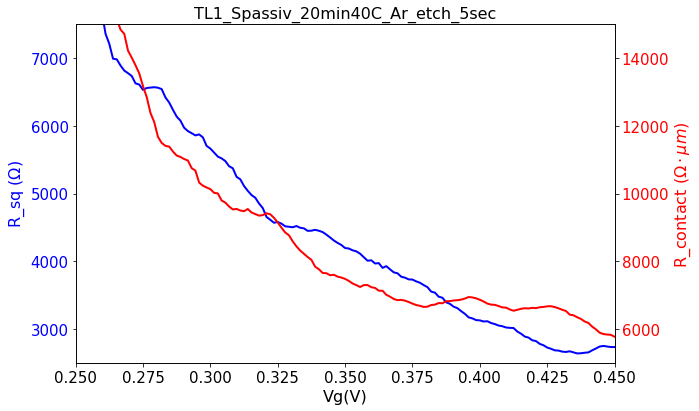

In [82]:
fig, ax = plt.subplots(1, figsize = (10,6), tight_layout = True)
ax2 = ax.twinx()

ax.plot(vgate, Rs_sq, label = 'R_sq', linewidth = 2, color = 'blue')
ax2.plot(vgate, Rs_contact, label = 'R_contact', linewidth = 2, color = 'red')

ax2.set_ylabel(r'R_contact ($\Omega \cdot \mu m $)', color = 'red')  # we already handled the x-label with ax1
ax2.tick_params(axis='y',  labelcolor = 'red')

ax.set_ylabel(r'R_sq ($\Omega$)', color = 'blue')  # we already handled the x-label with ax1
ax.tick_params(axis='y',  labelcolor = 'blue')

# ax.legend(fontsize = 16)
ax.set_xlim(0.25, 0.45)
ax.set_ylim(2500, 7500)
ax2.set_ylim(5000, 15000)
ax.set_xlabel('Vg(V)')
# ax.set_ylabel(r'R($\Omega$)')
plt.title('TL1_Spassiv_20min40C_Ar_etch_5sec', fontsize = 16)
plt.savefig('../plots/Rs_vs_gates_TL1_redo.png')

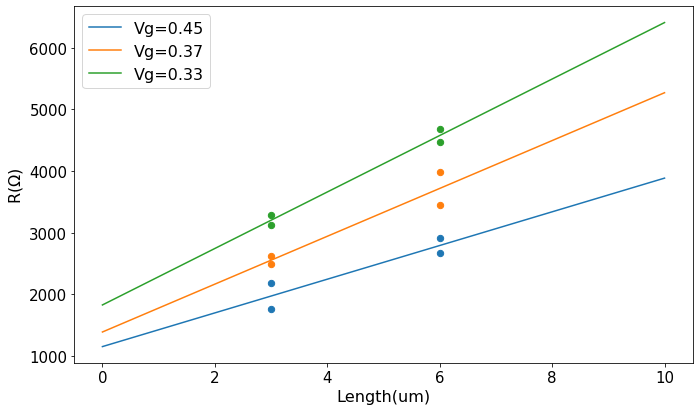

In [86]:
fig, ax = plt.subplots(1, figsize = (10,6), tight_layout = True)

x_to_plot = np.linspace(0,10, 20)

for target_gate_idx in [0,60,90]:
    ax.scatter(lengths, all_Rs[target_gate_idx,:], s = 40)
    
    resistances_to_fit = all_Rs[target_gate_idx,:]
    fit_vals = np.polyfit(lengths, resistances_to_fit, 1)
    ax.plot(x_to_plot, x_to_plot*fit_vals[0]+fit_vals[1], label = 'Vg={:.2f}'.format(vgate[target_gate_idx]))
    
ax.legend()
ax.set_xlabel('Length(um)')
ax.set_ylabel(r'R($\Omega$)')
plt.savefig('../plots/Rs_vs_gates_TL1_fit_redo.png')

In [73]:
dataset_ids = np.arange(12,16)